In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

import ast

import datetime
from functools import reduce

from itertools import product
from tqdm import tqdm
import joblib

from pykalman import KalmanFilter, UnscentedKalmanFilter

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit

from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

import xgboost as xgb

# from scipy.stats import rayleigh, poisson
from scipy.optimize import curve_fit


from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import KFold

from keras.losses import KLDivergence

from keras import backend as K

from keras.optimizers import SGD
from keras.models import *
from keras.layers import *
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
# from tensorflow.keras.constraints import MaxNorm
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping




def get_pif(path):
        df = pd.read_excel(path, sheet_name="Config")
        df = df.fillna("XXXXX")
        return list(df['PIF'])

def STR_TO_DT(df, col_horaire):
    df_temp = df
    l_dt = []
    for t in range(df.shape[0]):
        TSTR =  str(df[col_horaire][t])
        if len(TSTR)<10:
            l = [int(i) for i in TSTR.split(':')]
            l_dt.append(datetime.time(hour=l[0], minute=l[1], second=0))
        else:
            TSTR = TSTR[10:]
            l = [int(i) for i in TSTR.split(':')]
            l_dt.append(datetime.time(hour=l[0], minute=l[1], second=0))
    
    df[col_horaire] = l_dt
    return df_temp
    

def cat_num_col(df):
        
    numerical_col = ['Local Date', 'Horaire théorique', 'Pax LOC TOT', 'Pax CNT TOT', 'PAX TOT']
    categorical_col_bool = ~df.columns.isin(numerical_col)
    categorical_col = []

    for c, i in zip(df.columns, range(len(df.columns))):
        if categorical_col_bool[i] == True:
            categorical_col.append(c)
    categorical_col

    df[categorical_col] = df[categorical_col].astype(str)

    return df

def print_num_vol(df, type_mvt, col_libel, terminaux):
    x = df.loc[(df['A/D'] == type_mvt) & (df[col_libel].isin(terminaux))]
    s = ""
    for n in pd.unique(x['Num Vol']):
        s += n + ";"

    # to copy/paste for SAPBO request
    print("Vols:")
    print(s[:-1])
    print("Nombre de vol sur la période:", len(pd.unique(x['Num Vol'])))
    print()

    txt_file = open('liste_num_vol.txt', 'w')
    txt_file.write(s[:-1])
    txt_file.close()

def polynomial(x, a, b, c, d, e, f):
    # conditions aux limites: on veut 0 pax a t-4h et 0 pax a t
    # alors on sait que quand on évalue le poly en 0 et 25 on a p(0) = 0 et p(25) = 0
    # donc 0 et 25 sont des racines réelles => on peut factoriser par x-0 et x-25

    return x * (x-25) * (a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f)


def kalman_smoothing(y):
    kf = KalmanFilter(transition_matrices=[1],
                    observation_matrices=[1],
                    initial_state_mean=0,
                    initial_state_covariance=1,
                    observation_covariance=1,
                    transition_covariance=1)
    
    kf.em(y)
    smoothed_state_means, _ = kf.smooth(y)
    return smoothed_state_means.flatten()


def get_x_previ_df(path, sheet_name, col_horaire):
    df = pd.read_excel(path, sheet_name)
    df.drop(['Unnamed: 0', 'Affectation', 'Etat du vol'], axis=1, inplace=True)
    df['Porteur'].fillna('MP', inplace=True)
    df['Libellé terminal'] = df['Libellé terminal'].str.replace("T1_Inter","Terminal 1")
    df['Libellé terminal'] = df['Libellé terminal'].str.replace("T1_5","Terminal 1_5")
    df['Libellé terminal'] = df['Libellé terminal'].str.replace("T1_6","Terminal 1_6")
    df['Cie Ope'].dropna(inplace=True)
    df['Num Vol'].dropna(inplace=True)

    numerical_col = ['Local Date', 'Horaire théorique', 'Pax LOC TOT', 'Pax CNT TOT', 'PAX TOT']
    categorical_col = ~df.columns.isin(numerical_col)

    l_date = pd.to_datetime(df['Local Date'].unique().tolist()).date
    l_date = sorted(l_date)

    return df, l_date


def get_x_rea_df(path_file):
    x_rea_df = pd.read_csv(path_file, sep=',')
    x_rea_df.rename(columns=
                    {"Année":"Year", 
                    "Mois":"month",
                    "Plage Hub":"Plage",
                    "Type porteur":"Porteur",
                    "Code aéroport IATA":"Prov Dest",
                    "Code IATA compagnie":'Cie Ope',
                    "Type de mouvement":"A/D",
                    "Terminal":"Libellé terminal",
                    "Nombre de passagers réalisés":"PAX TOT",
                    "Jour":"Local Date",
                    "Numéro de vol":"Num Vol",
                    "Type de contact":"Contact/Large",
                    "Heure théorique":'Horaire théorique'},
                    inplace=True)

    x_rea_df['Local Date'] = pd.to_datetime(x_rea_df['Local Date'], format="%d/%m/%Y")
    x_rea_df['Local Date'] = x_rea_df['Local Date'].apply(lambda x: x.strftime("%d/%m/%Y"))

    x_rea_df['Horaire théorique'] = pd.to_datetime(x_rea_df['Horaire théorique'], format="%H:%M", errors='coerce').dt.time
    x_rea_df[['Pax LOC TOT', 'Pax CNT TOT']] = 0

    x_rea_df['A/D'] = x_rea_df['A/D'].str.replace("Départ","D")
    x_rea_df['A/D'] = x_rea_df['A/D'].str.replace("Arrivée","A")

    # x_rea_df['Contact/large'] = x_rea_df['Contact/Large'].str.replace("au contact","Contact")
    # x_rea_df['Contact/large'] = x_rea_df['Contact/Large'].str.replace("au large","Large")

    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("salle L","T2E-L")

    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("salle K","T2E-K")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("salle L","T2E-L")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("salle M","T2E-M")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("D","T2D")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("B","T2B")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("A","T2A")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("salle M","T2E-M")

    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("Jonction","Terminal 1")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("sat5","Terminal 1_5")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("sat6","Terminal 1_6")

    ind = x_rea_df['Salle corrigée'].loc[x_rea_df['Salle corrigée'].isin(['Terminal 1', 'Terminal 1_5', 'Terminal 1_6'])].index
    x_rea_df['Libellé terminal'].iloc[ind] = x_rea_df['Salle corrigée'].iloc[ind]

    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Lundi","Monday")
    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Mardi","Thuesday")
    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Mercredi","Wednesday")
    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Jeudi","Thursday")
    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Vendredi","Friday")
    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Samedi","Saturday")
    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Dimanche","Sunday")


    x_rea_df['Porteur'] = x_rea_df['Porteur'].str.replace('Gros porteur', "GP")
    x_rea_df['Porteur'] = x_rea_df['Porteur'].str.replace('Moyen porteur', "MP")
    
    try:
        x_rea_df.drop(['Compagnie' ,'Contact/Large', 'Immatriculation'], axis=1, inplace=True)
    except ValueError:
        pass

    x_rea_df = x_rea_df.dropna().reset_index(drop=True)
    x_rea_df = cat_num_col(x_rea_df)

    # ajout des vacances / jours fériés / ponts / grèves
    calendrier_gouv = pd.read_csv(r"calendar_complete_from_data_gouv.csv", sep=',')
    calendrier_gouv['date'] = pd.to_datetime(calendrier_gouv['date'], format="%Y-%m-%d")
    calendrier_gouv['date'] = calendrier_gouv['date'].apply(lambda x: x.strftime("%d/%m/%Y"))
    print("date exemple rea :", x_rea_df['Local Date'].iloc[0])
    print("date exemple calendrier :", calendrier_gouv['date'].iloc[0])


    calendrier_gouv.fillna('non_ferie', inplace=True)
    x_rea_df = pd.merge(x_rea_df, calendrier_gouv, left_on='Local Date', right_on='date', how='left')
    x_rea_df.drop(columns=['date'], axis=1, inplace=True)
    return x_rea_df


def get_y_rea_presentation(path):
    y_df = pd.read_csv(path, sep=',')
    y_df.drop(['Faisceau géographique', 'Heure Passage', 'Salle', 'Terminal de lecture', 'Groupe Position'], axis=1, inplace=True)
    y_df['Jour'] = pd.to_datetime(y_df['Jour'], format="%d/%m/%Y")
    y_df['Tranche Presentation'] = pd.to_datetime(y_df['Tranche Presentation'], format="%H:%M", errors="coerce").dt.time

    modified_df = y_df.copy()


    filtered_rows = modified_df[modified_df['Tranche Presentation'] > datetime.time(hour=4)]
    grouped_filtered_rows = filtered_rows.groupby(['Jour', 'Numéro de vol'])['Nb de passages'].sum().reset_index()

    time_range = pd.date_range('00:00', '04:00', freq='10min').time


    processed_y_df = pd.merge(modified_df, grouped_filtered_rows, on=['Jour', 'Numéro de vol'], suffixes=('', '_sum'), how='left')
    for t in time_range:
        processed_y_df.loc[processed_y_df['Tranche Presentation'] == t, 'Nb de passages'] += processed_y_df['Nb de passages_sum'].fillna(0) / 25
    processed_y_df.drop(columns='Nb de passages_sum', inplace=True)
    processed_y_df = processed_y_df.loc[processed_y_df['Tranche Presentation'] <= datetime.time(hour=4)]


    all_combinations = list(product(processed_y_df['Jour'].unique(), processed_y_df['Numéro de vol'].unique(), time_range))
    new_df = pd.DataFrame(all_combinations, columns=['Jour', 'Numéro de vol', 'Tranche Presentation'])

    full_y_df = pd.merge(new_df, processed_y_df, on=['Jour', 'Numéro de vol', 'Tranche Presentation'], how='left')

    # Fill NA
    filled_y_df = full_y_df.copy()
    filled_y_df['Code IATA compagnie'] = filled_y_df.groupby(['Jour', 'Numéro de vol'])['Code IATA compagnie'].ffill().bfill()
    filled_y_df['Horaire théorique'] = filled_y_df.groupby(['Jour', 'Numéro de vol'])['Horaire théorique'].ffill().bfill()
    filled_y_df['Nb de passages'].fillna(0, inplace=True)


    sum_y_df_duplicate = filled_y_df.groupby(['Jour', 'Numéro de vol', 'Tranche Presentation']).sum().reset_index()
    filled_y_df.drop_duplicates(subset=['Jour', 'Numéro de vol', 'Tranche Presentation'], keep=False, inplace=True)
    filled_y_df = pd.concat([filled_y_df, sum_y_df_duplicate])
    filled_y_df.sort_values(by=['Jour', 'Numéro de vol', 'Tranche Presentation'], inplace=True)
    filled_y_df.reset_index(drop=True, inplace=True)

    filled_y_df = filled_y_df[~filled_y_df.duplicated(subset=['Jour', 'Numéro de vol', 'Tranche Presentation'], keep='first')].reset_index(drop=True)


    sum_before_processing = y_df['Nb de passages'].sum()
    sum_after_processing = filled_y_df['Nb de passages'].sum()

    print(f"Before processing Nb Pax {sum_before_processing}")
    print(f"After processing Nb Pax {sum_after_processing}")
    print(f"Delta of Nb Pax: {sum_before_processing - sum_after_processing}")

    filled_y_df['Nb de passages'] *= (1+(sum_before_processing - sum_after_processing)/sum_before_processing)

    sum_before_processing = y_df['Nb de passages'].sum()
    sum_after_processing = filled_y_df['Nb de passages'].sum()

    print(f"Before processing Nb Pax {sum_before_processing}")
    print(f"After processing Nb Pax {sum_after_processing}")
    print(f"Delta of Nb Pax: {sum_before_processing - sum_after_processing}")
    return filled_y_df


class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, object_col):
        """Encode the data based on object column provided
        """
        self.object_col = object_col

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        dummy_df = pd.get_dummies(X[self.object_col], drop_first=True)
        X = X.drop(X[self.object_col], axis=1)
        X = pd.concat([dummy_df, X], axis=1)
        return X
    
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, object_cols):
        """Encode the data based on object columns provided using label encoding
        """
        self.object_cols = object_cols
        self.encoders = {}

    def fit(self, X, y=None):
        for col in self.object_cols:
            encoder = LabelEncoder()
            encoder.fit(X[col])
            self.encoders[col] = encoder
        return self

    def transform(self, X, y=None):
        for col, encoder in self.encoders.items():
            X[col] = encoder.transform(X[col])
        return X
    
class CustomNumericalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, object_col):
        """Encode the data based on object column provided
        """
        self.object_col = object_col

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        sc = StandardScaler()
        X[self.object_col] = sc.fit_transform(X[self.object_col])
        return X
    
# class CustomTimeEncoder(BaseEstimator, TransformerMixin):
#     def __init__(self, time_col):
#         self.object_col = time_col

#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X, y=None):
#         if self.object_col != 'Local Date':
#             X['sin_time'] = np.sin(2 * np.pi * pd.to_timedelta(X[self.object_col].astype(str)).dt.total_seconds()/86400)
#             X['cos_time'] = np.cos(2 * np.pi * pd.to_timedelta(X[self.object_col].astype(str)).dt.total_seconds()/86400)
#             X = X.drop(self.object_col, axis=1)
#         else:
#             X = X.drop(self.object_col, axis=1)
#         return X
    

class CustomTimeEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, time_col):
        self.object_col = time_col

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.object_col == 'Horaire théorique':
            X['sin_time'] = np.sin(2 * np.pi * pd.to_timedelta(X[self.object_col].astype(str)).dt.total_seconds()/86400)
            X['cos_time'] = np.cos(2 * np.pi * pd.to_timedelta(X[self.object_col].astype(str)).dt.total_seconds()/86400)
            X = X.drop(self.object_col, axis=1)
        if self.object_col == 'Semaine':
            X['semaine_sin_time'] = np.sin(2 * np.pi * X[self.object_col]/52)
            X['semaine_cos_time'] = np.cos(2 * np.pi * X[self.object_col]/52)
            X = X.drop(self.object_col, axis=1)
        if self.object_col == 'month':
            X['month_sin_time'] = np.sin(2 * np.pi * X[self.object_col]/12)
            X['month_cos_time'] = np.cos(2 * np.pi * X[self.object_col]/12)
            X = X.drop(self.object_col, axis=1)
        if self.object_col == 'Local Date':
            X = X.drop(self.object_col, axis=1)
        return X
    
class CustomTargetPrevisionEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, y):
        return self
    
    def transform(self, y):
        x = np.linspace(0, 25, 26) # correspond aux pas de 10min entre 0 et 4h
        transformed_y = np.zeros((len(y), 26))
        for i, coeffs in enumerate(y):
            for j, x in enumerate(range(26)):
                res = polynomial(x, *coeffs)
                transformed_y[i, j] = max(res, 0)
            sum = np.sum(transformed_y[i])
            if sum!=0:
                transformed_y[i] /= sum
        return transformed_y
    
class CustomTargetRepartitionEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, target_col):
        self.object_col = target_col
    
    def fit(self, y):
        return self
    
    def transform(self, y):
        y[self.object_col] = y[self.object_col].astype(int)
        y['tot_sum'] = y.loc[:, self.object_col].sum(1)
        for c in self.object_col:
            y[c] /= y['tot_sum']
        
        y.drop('tot_sum', axis=1,inplace=True)
        return y

In [2]:
path_file = r'C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\pgrm\x_rea_pgrm.csv'
x_rea_df = get_x_rea_df(path_file)
x_rea_df

C:\Users\nazzaren\AppData\Local\Temp\ipykernel_25304\715797531.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_rea_df['Libellé terminal'].iloc[ind] = x_rea_df['Salle corrigée'].iloc[ind]


date exemple rea : 03/01/2022
date exemple calendrier : 01/09/2017


,Year,month,Semaine,Local Date,Jour de la semaine,Plage,Horaire théorique,A/D,Libellé terminal,Salle corrigée,...,Pax LOC TOT,Pax CNT TOT,is_ferie,nom_jour_ferie,Zone A,Zone B,Zone C,Zone A vacance,Zone B vacance,Zone C vacance
0,2022,1,1,03/01/2022,Monday,P0,00:35:00,A,T2A,T2A,...,0,0,0,non_ferie,0,0,0,non_ferie,non_ferie,non_ferie
1,2022,1,1,03/01/2022,Monday,P1,05:00:00,A,T2E,T2E-K,...,0,0,0,non_ferie,0,0,0,non_ferie,non_ferie,non_ferie
2,2022,1,1,03/01/2022,Monday,P1,05:20:00,A,T2E,T2E-M,...,0,0,0,non_ferie,0,0,0,non_ferie,non_ferie,non_ferie
3,2022,1,1,03/01/2022,Monday,P1,05:30:00,A,T2A,T2A,...,0,0,0,non_ferie,0,0,0,non_ferie,non_ferie,non_ferie
4,2022,1,1,03/01/2022,Monday,P1,05:40:00,A,T2E,T2E-K,...,0,0,0,non_ferie,0,0,0,non_ferie,non_ferie,non_ferie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729157,2023,12,52,31/12/2023,Sunday,P7,23:20:00,D,T2E,T2E-K,...,0,0,0,non_ferie,1,1,1,Vacances de Noël,Vacances de Noël,Vacances de Noël
729158,2023,12,52,31/12/2023,Sunday,P7,23:20:00,D,T2E,T2E-K,...,0,0,0,non_ferie,1,1,1,Vacances de Noël,Vacances de Noël,Vacances de Noël
729159,2023,12,52,31/12/2023,Sunday,P7,23:20:00,D,T2E,T2E-K,...,0,0,0,non_ferie,1,1,1,Vacances de Noël,Vacances de Noël,Vacances de Noël
729160,2023,12,52,31/12/2023,Sunday,P7,23:30:00,A,T2D,T2D,...,0,0,0,non_ferie,1,1,1,Vacances de Noël,Vacances de Noël,Vacances de Noël


In [ ]:
# path_x = r'C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\pgrm'
# file_x = r"\pgrm_aout_septembre.xlsx"
# sheet_name_x = "pgrm_complet"

# col_horaire = 'Horaire théorique'
# x_previ_df, l_date = get_x_previ_df(path_x + file_x, sheet_name_x, col_horaire)

# # L_pif = get_pif(r"fichier_config_PIF.xlsx")


# table_faisceau_iata = pd.read_excel("table_faisceau_IATA.xlsx")
# table_faisceau_iata.rename(columns={"Code aéroport IATA":"Prov Dest"}, inplace=True)
# table_faisceau_iata = table_faisceau_iata[['Prov Dest','Faisceau géographique']]
# x_previ_df = x_previ_df.merge(table_faisceau_iata,how='left', left_on='Prov Dest', right_on='Prov Dest')
# x_previ_df['Faisceau géographique'].fillna('Autre Afrique', inplace=True)
# x_previ_df['Jour de la semaine'] = x_previ_df['Local Date'].dt.day_name()
# x_previ_df[col_horaire] = pd.to_datetime(x_previ_df[col_horaire], format="%H:%M:%S", errors='coerce').dt.time

# x_previ_df['Year'] = x_previ_df['Local Date'].dt.year
# x_previ_df['month'] = x_previ_df['Local Date'].dt.month
# x_previ_df['month_name'] = x_previ_df['Local Date'].dt.month_name()
# x_previ_df['day'] = x_previ_df['Local Date'].dt.day
# x_previ_df.drop(columns=['Jour (nb)'], axis=1, inplace=True)
# x_previ_df = cat_num_col(x_previ_df)

# x_previ_df

In [3]:
# print('Terminaux du pgrm prévisionnel:')
# print('Libellé terminal:\n', x_previ_df['Libellé terminal'].unique())
# print()
print('Terminaux du pgrm réalisé:')
print('Libellé terminal:\n', x_rea_df['Libellé terminal'].unique())
print('Salle corrigée:\n', x_rea_df['Salle corrigée'].unique())

Terminaux du pgrm réalisé:
Libellé terminal:
 ['T2A' 'T2E' 'T2B' 'T2C' 'T2F' 'Terminal 1' 'Terminal 1_5' 'T2D' 'T2G'
 'T3' 'Terminal 1_6' 'CDGF' 'T1']
Salle corrigée:
 ['T2A' 'T2E-K' 'T2E-M' 'T2E-L' 'T2D' 'C' 'F2' 'F1' 'T2B' 'Terminal 1'
 'Terminal 1_5' 'T2G' 'T3-T2A' 'T3-T2B' 'Terminal 1_6' 'N/T2D' 'T2D54']


In [ ]:
terminaux_previ_east = ['Terminal 1', 'Terminal 1_6', 'Terminal 1_5',  
                        'Terminal 2A', 'Terminal 2B', 'Terminal 2C' 'Terminal 2D', 
                        'Terminal 3']
terminaux_previ_west = ['EK', 'EL', 'EM', 'F', 'G']
terminaux_rea_east = ['Terminal 1', 'Terminal 1_5', 'Terminal 1_6', 'T2A', 'T2B', 'T2D', 'T3-T2B',  'T3-T2A', ]
terminaux_rea_west = ['F1', 'F2', 'T2E-K', 'T2E-L', 'T2E-M', 'T2F', 'T2G', 'T2F']

# print_num_vol(x_previ_df, 'D', "Libellé terminal", terminaux_previ_east)
# print_num_vol(x_previ_df, 'D', "Libellé terminal", terminaux_previ_west)
print_num_vol(x_rea_df, 'D', "Salle corrigée", terminaux_rea_east)
# print_num_vol(x_rea_df, 'D', "Salle corrigée", terminaux_rea_west)


In [ ]:
# [Tranche Passage] = ALaDate(Remplacer(Gauche([Tranche 10 minutes passage];8);".";":");"HH:mm:ss")
# [Tranche Théorique] = ALaDate(Remplacer(Gauche([Tranche théorique 10 minutes];8);".";":");"HH:mm:ss")
# [Tranche Presentation minute]=HeureEntre([Tranche Passage];[Tranche Théorique];PériodeMinute)

# [Tranche Presentation] = FormatNombre(Plancher([Tranche Presentation minute]/60);"0")+":"+FormatNombre(Mod([Tranche Presentation minute];60);"00")


In [4]:
from copy import deepcopy


path_y_rea_presentation = r'C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\rea'
# file_name_y_rea_presentation_2022 = r"\y_rea_presentation_2022.csv"
# file_name_y_rea_presentation_2023 = r"\y_rea_presentation_2023.csv"
file_name_y_rea_presentation_2024 = r"\y_rea_presentation_2024.csv"


# y_rea_presentation_2022 = get_y_rea_presentation(path_y_rea_presentation + file_name_y_rea_presentation_2022)
# y_rea_presentation_2023 = get_y_rea_presentation(path_y_rea_presentation + file_name_y_rea_presentation_2023)
y_rea_presentation_2024 = get_y_rea_presentation(path_y_rea_presentation + file_name_y_rea_presentation_2024)

# y_rea_presentation = pd.concat([y_rea_presentation_2022, y_rea_presentation_2023, y_rea_presentation_2024], axis=0)
y_rea_presentation = deepcopy(y_rea_presentation_2024)

Before processing Nb Pax 9814844
After processing Nb Pax 9755417.640000002
Delta of Nb Pax: 59426.35999999754
Before processing Nb Pax 9814844
After processing Nb Pax 9814484.188650692
Delta of Nb Pax: 359.8113493081182
Before processing Nb Pax 12934766
After processing Nb Pax 12866114.800000016
Delta of Nb Pax: 68651.19999998435
Before processing Nb Pax 12934766
After processing Nb Pax 12934401.634130409
Delta of Nb Pax: 364.3658695910126


In [5]:
def y_rea_presentation_factorized(y_df):
    y_df['Jour de la semaine'] = y_df['Jour'].dt.day_name()
    y_df['Mois de l annee'] = y_df['Jour'].dt.month
    grouped = y_df.groupby(['Mois de l annee', 'Jour de la semaine', 'Numéro de vol', 'Tranche Presentation'])
    y_df.drop(columns=['Jour de la semaine', 'Mois de l annee'], inplace=True)
    # grouped = filled_y_df.groupby(['Jour de la semaine', 'Numéro de vol', 'Tranche Presentation'])
    return grouped['Nb de passages'].mean().reset_index()

y_rea_presentation_facto = y_rea_presentation_factorized(y_rea_presentation)
y_rea_presentation_facto

,Mois de l annee,Jour de la semaine,Numéro de vol,Tranche Presentation,Nb de passages
0,1,Friday,3F928,00:00:00,0.0
1,1,Friday,3F928,00:10:00,0.0
2,1,Friday,3F928,00:20:00,0.0
3,1,Friday,3F928,00:30:00,0.0
4,1,Friday,3F928,00:40:00,0.0
...,...,...,...,...,...
3053395,12,Wednesday,ZT5492,03:20:00,0.0
3053396,12,Wednesday,ZT5492,03:30:00,0.0
3053397,12,Wednesday,ZT5492,03:40:00,0.0
3053398,12,Wednesday,ZT5492,03:50:00,0.0


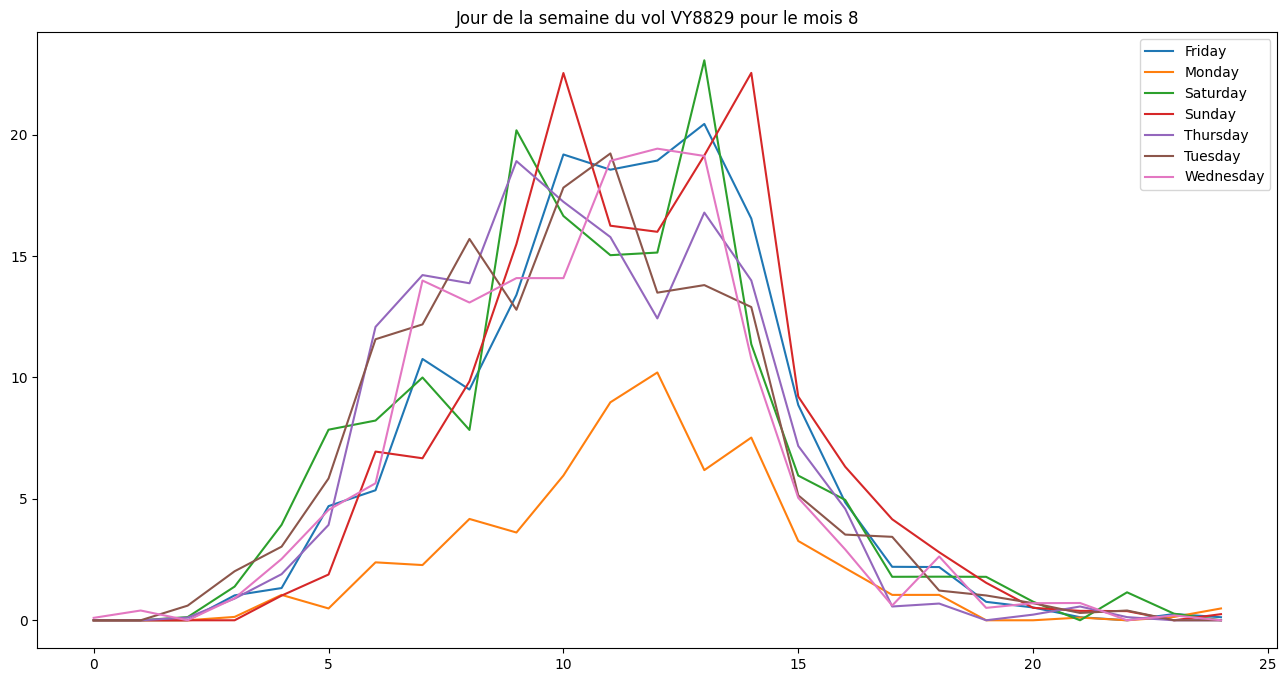

In [35]:
# def plot_weekly_pax_rea(mean_passages, num, month_to_plot):
#     plt.figure(figsize=(16, 8))
#     for day in mean_passages['Jour de la semaine'].unique().tolist():
#         plt.plot(mean_passages['Nb de passages'].loc[(mean_passages['Jour de la semaine'] == day) & (mean_passages['Numéro de vol'] == num) & (mean_passages['Mois de l annee'] == month_to_plot)].values, label=day)
#     plt.title(f"Jour de la semaine du vol {num} pour le mois {month_to_plot}")
#     plt.legend()
#     plt.show()

# plot_weekly_pax_rea(y_rea_presentation_facto, "VY8829", 8)


In [37]:
def UKS(y, smoothing_factor=50):
    ukf = UnscentedKalmanFilter(observation_covariance=smoothing_factor)
    (filtered_state_means, _) = ukf.filter(y)
    return filtered_state_means


def get_x_y_data(df, mois_annee, jour_semaine, num_vol, mois_annee_col_name, jour_semaine_col_name, num_vol_col_name):
    y = df['Nb de passages'].loc[(df[mois_annee_col_name] == mois_annee) & (df[jour_semaine_col_name] == jour_semaine) & (df[num_vol_col_name] == num_vol)].values.ravel()
    x = np.linspace(0, len(y), len(y))
    y = y[::-1] # on inverse les valeurs pour coller a la logique du temps => en t = 0 on est 4h avant le vol, et en t=25 on est a 0h du vol
    if sum(y) != 0:
        y = y/sum(y)
    return x, y


def fit_poly(x, y):
    if y.any() != 0:
        try:
            param, _ = curve_fit(polynomial, x, y, maxfev=30)
        except RuntimeError:
            param = np.nan
        return param
    else:
        return np.nan

In [38]:
def get_fitted_poly_flight(df, isKalmanSmoothed, mois_annee_col_name, jour_semaine_col_name, num_vol_col_name):

    dictionnaire_vol_jour = {}
    week = df[jour_semaine_col_name].unique().tolist()
    flights = df[num_vol_col_name].unique().tolist()
    months = df[mois_annee_col_name].unique().tolist()

    if isKalmanSmoothed:
        print('Start of Kalman smoothed fitting...')
        for num_vol in tqdm(flights):
            dictionnaire_vol_jour[num_vol] = {}
            for mois in months:
                dictionnaire_vol_jour[num_vol][f"month_{mois}"] = {}
                for jour_semaine in week:
                    x, y = get_x_y_data(df, mois_annee=mois, jour_semaine=jour_semaine, num_vol=num_vol, mois_annee_col_name=mois_annee_col_name, 
                                        jour_semaine_col_name=jour_semaine_col_name, num_vol_col_name=num_vol_col_name)
                    y_kalman = UKS(y, 2)
                    dictionnaire_vol_jour[num_vol][f"month_{mois}"][jour_semaine] = {"polynom_coefficients": fit_poly(x, y_kalman)}
    else:
        print('Start of fitting...')
        for num_vol in tqdm(flights):
            dictionnaire_vol_jour[num_vol] = {}
            for mois in months:
                dictionnaire_vol_jour[num_vol][f"month_{mois}"] = {}
                for jour_semaine in week:
                    x, y = get_x_y_data(df, mois_annee=mois, jour_semaine=jour_semaine, num_vol=num_vol, mois_annee_col_name=mois_annee_col_name, 
                                        jour_semaine_col_name=jour_semaine_col_name, num_vol_col_name=num_vol_col_name)
                    dictionnaire_vol_jour[num_vol][f"month_{mois}"][jour_semaine] = {"polynom_coefficients": fit_poly(x, y)}
    
    print('Fitting complete!')
    return dictionnaire_vol_jour

In [ ]:
# y_rea_presentation_facto['Cie Ope'] = y_rea_presentation_facto['Numéro de vol'].str[:2]
# y_rea_presentation_facto

In [ ]:
# y_rea_presentation_facto.groupby(['Mois de l annee', 'Jour de la semaine', 'Tranche Presentation', 'Cie Ope'])['Nb de passages'].mean().reset_index()

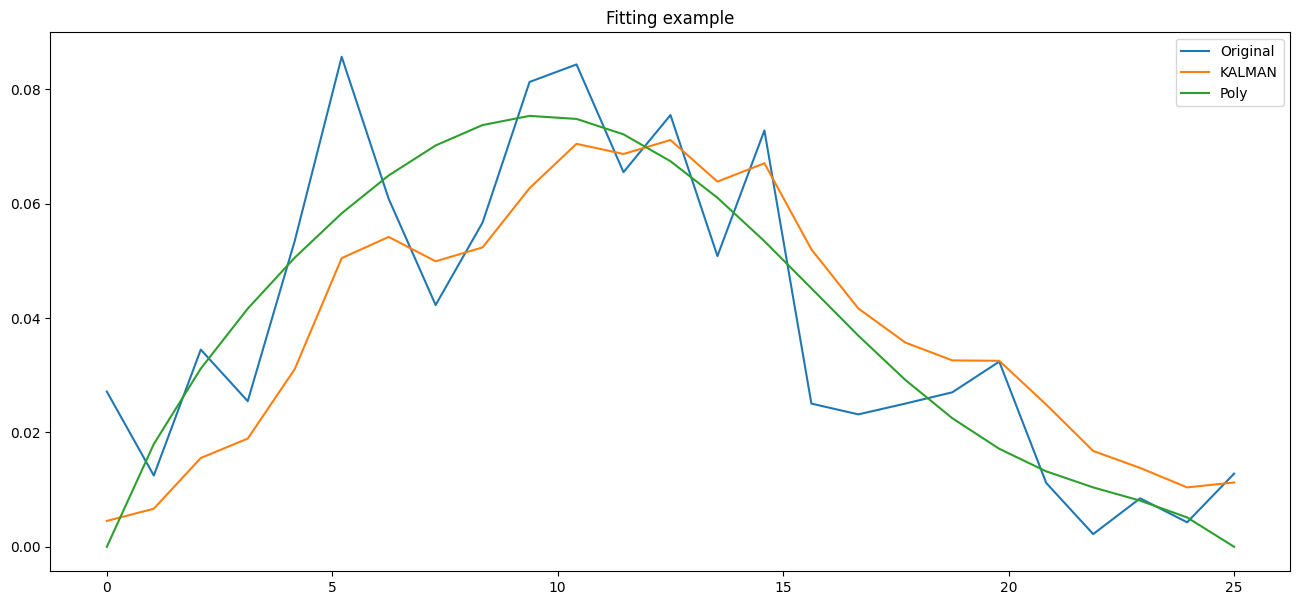

In [42]:
# x, y = get_x_y_data(y_rea_presentation_facto, 6, 'Monday', 'AA025', 'Mois de l annee', 'Jour de la semaine', 'Numéro de vol')
# plt.figure(figsize=(16, 7))
# plt.plot(x, y, label='Original')
# plt.plot(x, UKS(y, 5), label='KALMAN')
# plt.plot(x, (polynomial(x, *fit_poly(x, y)) * (1/sum(polynomial(x, *fit_poly(x, y))))), label='Poly')
# plt.title('Fitting example')
# plt.legend()
# plt.show()

In [ ]:
y_rea_presentation_fitted_24 = get_fitted_poly_flight(df=y_rea_presentation_facto, 
                                         isKalmanSmoothed=False, 
                                         mois_annee_col_name="Mois de l annee", 
                                         jour_semaine_col_name="Jour de la semaine", 
                                         num_vol_col_name="Numéro de vol")


####################### PRENDS BEAUCOUP DE TEMPS A EXECUTER ########################

In [ ]:
# y_rea_presentation_fitted_ks = get_fitted_poly_flight(df=y_rea_presentation_facto, 
#                                          isKalmanSmoothed=True, 
#                                          mois_annee_col_name="Mois de l annee", 
#                                          jour_semaine_col_name="Jour de la semaine", 
#                                          num_vol_col_name="Numéro de vol")



############ PRENDS ENCORE BEAUCOUP BEAUCOUP PLUS DE TEMPS A EXECUTER ################

In [43]:
############################## FITTED POLYNOMIAL CLASS FOR SAVING AND LOADING ##############################
import math
import json

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32,
                              np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        elif isinstance(obj, (np.nan)):
            return None
        return json.JSONEncoder.default(self, obj)
    

def nan2None(obj):
    if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
        return int(obj)
    elif isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    if isinstance(obj, dict):
        return {k:nan2None(v) for k,v in obj.items()}
    elif isinstance(obj, list):
        return [nan2None(v) for v in obj]
    elif isinstance(obj, float) and math.isnan(obj):
        return None
    return obj

class NanConverter(json.JSONEncoder):
    def encode(self, obj, *args, **kwargs):
        return super().encode(nan2None(obj), *args, **kwargs)
    
    
def save_fitted_y_rea_presentation(fitted_y_rea_presentation, path, name):
    dumped = json.dumps(fitted_y_rea_presentation, cls=NanConverter)
    with open(path + name, 'a') as f:
        f.write(dumped + '\n')
    f.close()

def load_fitted_y_rea_presentation(path, name):
    with open(path + name, 'r') as f:
        loaded = [json.loads(line) for line in f]
        f.close()
    return loaded[0]

In [44]:
path_fitted = r'C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\_fitted_y_rea_presentation'

In [ ]:
# SAVING FITTED CURVES AS JSON FILES FOR LATER USE IN THE APP (PREVNT 7H OF FITTING EACH TIME)
save_fitted_y_rea_presentation(y_rea_presentation_fitted_24, path=path_fitted, name=r'\fitted_poly_24.json')
# save_fitted_y_rea_presentation(y_rea_presentation_fitted_ks, path=path_fitted, name='fitted_poly_ks.json')

In [45]:
y_rea_presentation_fitted_22_23 = load_fitted_y_rea_presentation(path=path_fitted, name=r'\fitted_poly.json') # déja calculé, on charge uniquement
y_rea_presentation_fitted_24 = load_fitted_y_rea_presentation(path=path_fitted, name=r'\fitted_poly_24.json')


# y_rea_presentation_fitted_ks = load_fitted_y_rea_presentation(path=path_fitted, name=r'\fitted_poly_ks.json')

In [ ]:
y_rea_presentation_fitted = pd.concat([y_rea_presentation_fitted_22_23, y_rea_presentation_fitted_24], axis=0)

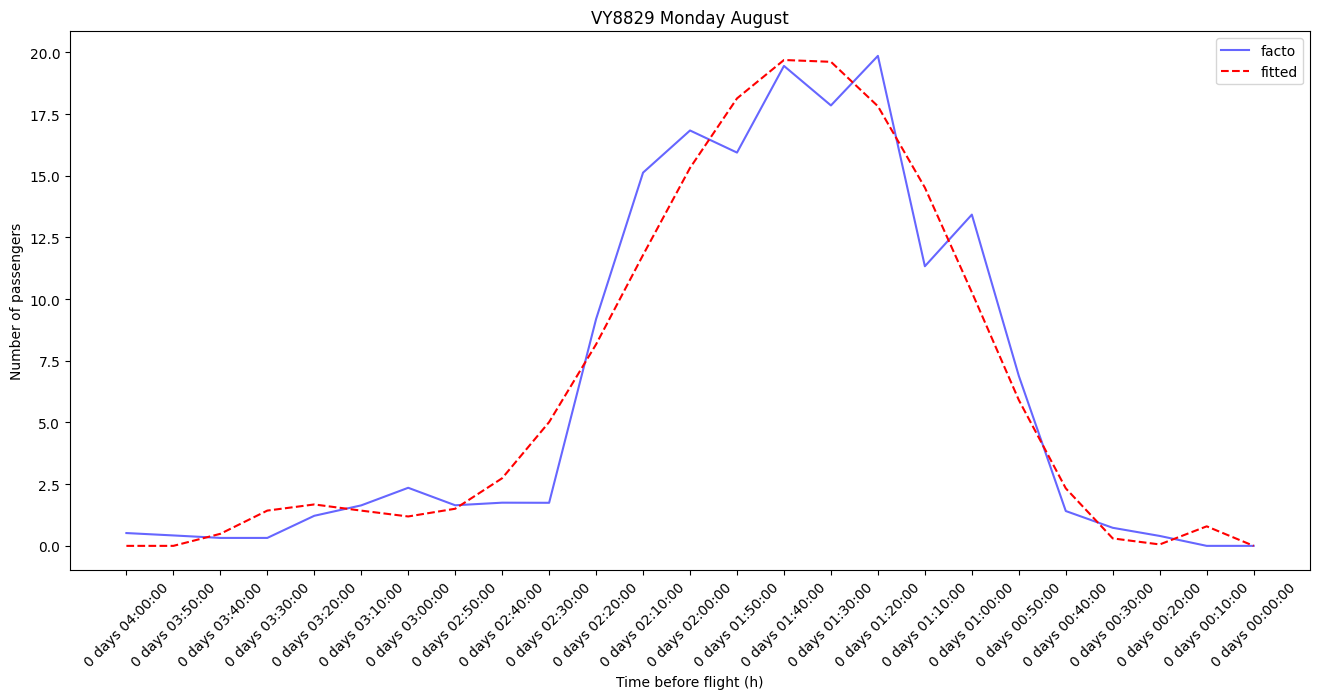

In [47]:
# plt.figure(figsize=(16, 7))
# plt.plot(y_rea_presentation_facto.loc[(y_rea_presentation_facto['Numéro de vol'] == 'VY8829') & (y_rea_presentation_facto['Jour de la semaine'] == 'Monday') & (y_rea_presentation_facto['Mois de l annee'] == 10)]['Nb de passages'][::-1].values, label='facto',  alpha=0.6, color='blue')
# # plt.plot(np.maximum(polynomial(np.linspace(0, 25, 25), *y_rea_presentation_fitted_ks['VY8829']['month_8']['Monday']['polynom_coefficients']) * y_rea_presentation_facto.loc[(y_rea_presentation_facto['Numéro de vol'] == 'EK072') & (y_rea_presentation_facto['Jour de la semaine'] == 'Monday') & (y_rea_presentation_facto['Mois de l annee'] == 10)]['Nb de passages'].values.sum(), 0), label='fitted_ks', color='orange', linestyle='--')
# plt.plot(np.maximum(polynomial(np.linspace(0, 25, 25), *y_rea_presentation_fitted['VY8829']['month_10']['Monday']['polynom_coefficients']) * y_rea_presentation_facto.loc[(y_rea_presentation_facto['Numéro de vol'] == 'VY8829') & (y_rea_presentation_facto['Jour de la semaine'] == 'Monday') & (y_rea_presentation_facto['Mois de l annee'] == 10)]['Nb de passages'].values.sum(), 0), label='fitted', color='red', linestyle='--')
# plt.xlabel('Time before flight (h)')
# plt.xticks(np.arange(0, 25, 1), pd.timedelta_range(start='4h', periods=25, freq='-10min'), rotation=45)
# plt.ylabel('Number of passengers')
# plt.title('VY8829 Monday August')
# plt.legend()
# plt.show()

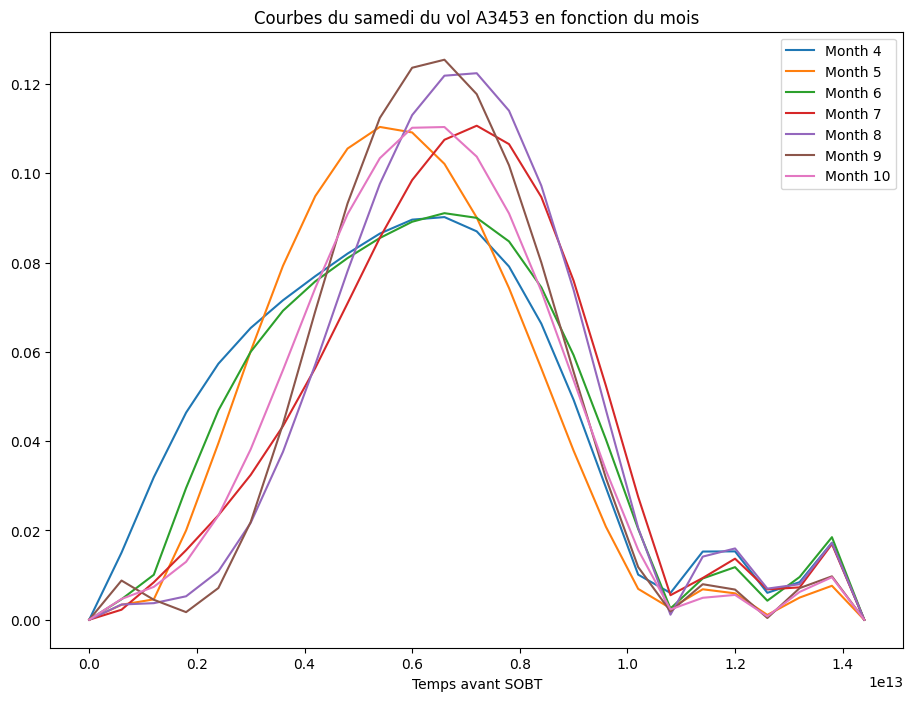

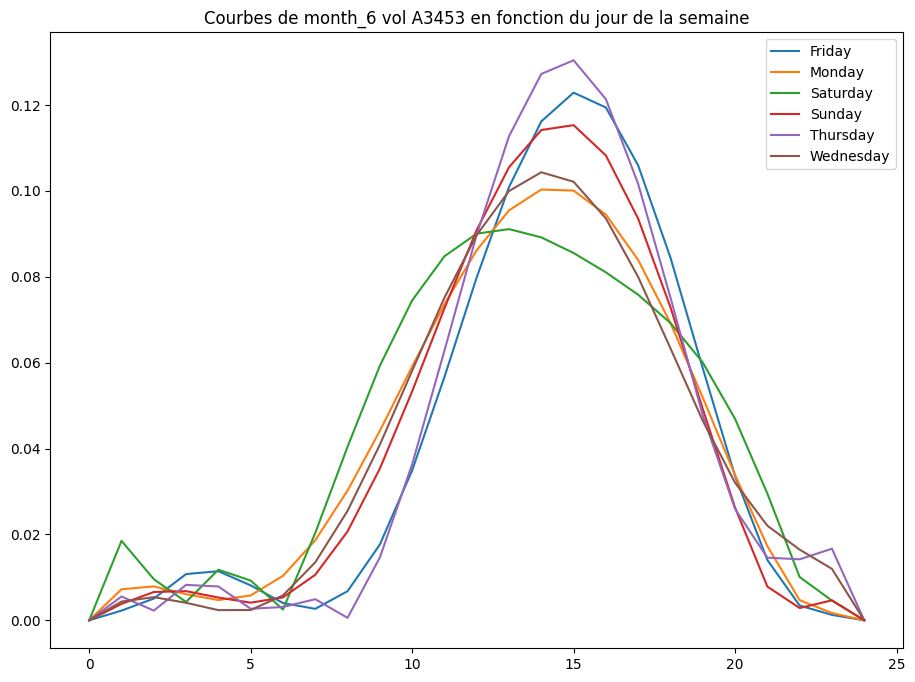

In [48]:
# num_vol_temp = "A3453"
# mois_temp = "month_6"

# time_steps = pd.timedelta_range(start='4h', periods=25, freq='-10min')

# plt.figure(figsize=(11, 8))
# for i in range(1, 12):
#     try:
        
#         plt.plot(time_steps, np.abs(polynomial(np.linspace(0, 25, 25), 
#                             *y_rea_presentation_fitted[num_vol_temp][f'month_{i}']['Saturday']['polynom_coefficients'])), 
#                             label=f"Month {i}")
#     except TypeError:
#         continue

# plt.legend()
# plt.xlabel('Temps avant SOBT')
# plt.title(f"Courbes du samedi du vol {num_vol_temp} en fonction du mois")
# plt.show()

# plt.figure(figsize=(11, 8))
# for j in y_rea_presentation_fitted['A3453']['month_1'].keys():
#     try:
#         plt.plot(np.abs(polynomial(np.linspace(0, 25, 25), 
#                             *y_rea_presentation_fitted[num_vol_temp][mois_temp][j]['polynom_coefficients'])), 
#                             label=j)
#     except TypeError:
#         continue
# plt.legend()

# plt.title(f"Courbes de {mois_temp} vol {num_vol_temp} en fonction du jour de la semaine")
# plt.show()

In [ ]:
# num_vol = np.random.choice(y_rea_presentation_facto['Numéro de vol'].unique().tolist())
# month = np.random.choice(y_rea_presentation_facto['Mois de l annee'].unique().tolist())
# day = np.random.choice(y_rea_presentation_facto['Jour de la semaine'].unique().tolist())

# while not y_rea_presentation_fitted[num_vol][f"month_{month}"][day]['polynom_coefficients'] == type(None):
#     num_vol = np.random.choice(y_rea_presentation_facto['Numéro de vol'].unique().tolist())
#     month = np.random.choice(y_rea_presentation_facto['Mois de l annee'].unique().tolist())
#     day = np.random.choice(y_rea_presentation_facto['Jour de la semaine'].unique().tolist())
#     print('NoneType encountered, retrying...')
#     time.sleep(1)

No flight ENT507 on Saturday.
Found data for EJU3810 on Saturday, month 6.


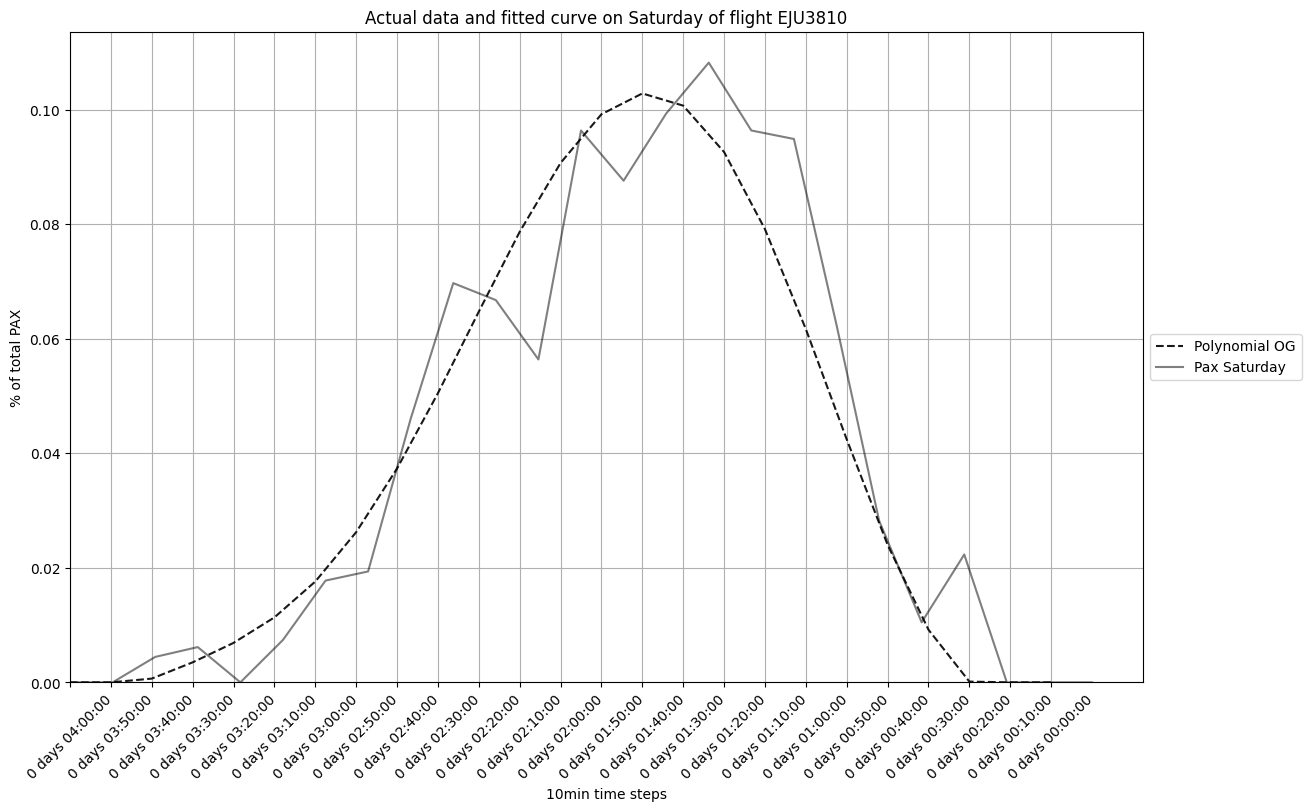

In [57]:
# num_vol = np.random.choice(y_rea_presentation_facto['Numéro de vol'].unique().tolist())
# month = np.random.choice(y_rea_presentation_facto['Mois de l annee'].unique().tolist())
# day = np.random.choice(y_rea_presentation_facto['Jour de la semaine'].unique().tolist())


# while type(y_rea_presentation_fitted[num_vol][f"month_{month}"][day]['polynom_coefficients']) == type(None):
#     print(f"No flight {num_vol} on {day}.")
#     num_vol = np.random.choice(y_rea_presentation_facto['Numéro de vol'].unique().tolist())
#     month = np.random.choice(y_rea_presentation_facto['Mois de l annee'].unique().tolist())
#     day = np.random.choice(y_rea_presentation_facto['Jour de la semaine'].unique().tolist())
# print(f"Found data for {num_vol} on {day}, month {month}.")

# x, y = get_x_y_data(y_rea_presentation_facto, 
#                     mois_annee=month, jour_semaine=day, num_vol=num_vol, 
#                     mois_annee_col_name='Mois de l annee', 
#                     jour_semaine_col_name='Jour de la semaine', 
#                     num_vol_col_name="Numéro de vol")
# y_kalman = UKS(y, 5)

# fig = plt.figure(figsize=(13, 8), layout="constrained")


# plt.plot(np.maximum(polynomial(np.linspace(0,25,25), *y_rea_presentation_fitted[num_vol][f"month_{month}"][day]['polynom_coefficients']), 0), label="Polynomial OG", c="black", linestyle="--", alpha=0.9)
# # plt.plot(polynomial(np.linspace(0,25,25), *y_rea_presentation_fitted_ks[num_vol][f"month_{month}"][day]['polynom_coefficients']), label="Polynomial KS", c="red", linestyle="-.", alpha=0.9)

# plt.plot(x, y, label=f"Pax {day}", c="black", linestyle="-", alpha=0.5)
# # plt.plot(x, y_kalman, label="Kalman smoothing", c="red", linestyle="-", alpha=0.4)

# plt.title(f"Actual data and fitted curve on {day} of flight {num_vol}")
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlabel("10min time steps")
# plt.xticks(np.arange(0, 25, 1), pd.timedelta_range(start='4h', periods=25, freq='-10min'), rotation=45)
# plt.ylabel("% of total PAX")
# plt.grid(True)
# plt.xlim(0)
# plt.ylim(0)
# plt.show()


In [ ]:
def format_fitted_dict(d, months_list):
    
    temp = pd.concat({k: pd.DataFrame(v) for k,v in d.items()}, axis=0).reset_index()
    rows = []

    # Iterate over each row in the original dataframe
    for index, row in temp.iterrows():
        # Iterate over each month column
        for month in months_list:
            # Extract the coefficient value from the month column
            coefficient = row[month]['polynom_coefficients']
            # Append the row data to the rows list
            rows.append([row['level_0'], row['level_1'], month, coefficient])

    # Create a new dataframe from the rows list
    new_df = pd.DataFrame(rows, columns=['Numéro de vol', 'Jour de la semaine', 'Mois', 'Coefficients'])
    new_df['Mois'] = new_df['Mois'].apply(lambda x: x.split('_')[1])
    return new_df

months_list = [f"month_{i}" for i in y_rea_presentation_facto['Mois de l annee'].unique().tolist()]
y_rea_final = format_fitted_dict(y_rea_presentation_fitted, months_list)
# y_rea_final_ks = format_fitted_dict(y_rea_presentation_fitted_ks, months_list)

In [ ]:
def merge_x_y(df, fitted_df):
    res = pd.merge(df, fitted_df, left_on=['month', 'Jour de la semaine', 'Num Vol'], right_on=['Mois', 'Jour de la semaine', 'Numéro de vol'], how='left')
    res.drop(columns=['Numéro de vol', 'Mois'], inplace=True)
    res.dropna(inplace=True)
    return res

data_rea = merge_x_y(x_rea_df, y_rea_final)
data_rea.to_csv(r'C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\pgrm\fitted_final_data_for_nn_rea.csv', index=False, sep=';', encoding='latin-1')
# data_rea_ks = merge_x_y(x_rea_df, y_rea_final_ks)
# data_rea_ks.to_csv(r'C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\pgrm\data_rea_ks.csv', index=False, sep=';', encoding='latin-1')


In [58]:
data_rea = pd.read_csv(r'C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\pgrm\fitted_final_data_for_nn_rea.csv', sep=';', encoding='latin-1')
data_rea

liste_greve = ['27/03/2023', '01/05/2023', '02/10/2023']
ind_greve = data_rea.loc[data_rea['Local Date'].isin(liste_greve)].index
data_rea.drop(ind_greve, inplace=True)
data_rea

,Year,month,Semaine,Local Date,Jour de la semaine,Plage,Horaire théorique,A/D,Libellé terminal,Salle corrigée,...,Pax CNT TOT,is_ferie,nom_jour_ferie,Zone A,Zone B,Zone C,Zone A vacance,Zone B vacance,Zone C vacance,Coefficients
0,2022,1,1,03/01/2022,Monday,P1,06:20:00,D,T2B,T2D,...,0,0,non_ferie,0,0,0,non_ferie,non_ferie,non_ferie,"[-8.588533007733398e-09, 5.506601929381359e-07..."
1,2022,1,1,03/01/2022,Monday,P1,06:45:00,D,T2B,T2D,...,0,0,non_ferie,0,0,0,non_ferie,non_ferie,non_ferie,"[-3.0777468134887295e-09, 2.43870114817093e-07..."
2,2022,1,1,03/01/2022,Monday,P1,07:00:00,D,T2A,T2A,...,0,0,non_ferie,0,0,0,non_ferie,non_ferie,non_ferie,"[-8.406959426721114e-09, 5.350355960170532e-07..."
3,2022,1,1,03/01/2022,Monday,P1,07:00:00,D,T2B,T2D,...,0,0,non_ferie,0,0,0,non_ferie,non_ferie,non_ferie,"[-1.0453616709120714e-08, 6.60989687838688e-07..."
4,2022,1,1,03/01/2022,Monday,P1,07:05:00,D,T2A,T2D,...,0,0,non_ferie,0,0,0,non_ferie,non_ferie,non_ferie,"[-3.0347074141553874e-08, 1.9374310014861067e-..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92618,2023,12,52,31/12/2023,Sunday,P6,22:00:00,D,T2D,T2B,...,0,0,non_ferie,1,1,1,Vacances de Noël,Vacances de Noël,Vacances de Noël,"[1.6417314966372632e-08, -1.1613044387095642e-..."
92619,2023,12,52,31/12/2023,Sunday,P6,22:00:00,D,T2D,T2B,...,0,0,non_ferie,1,1,1,Vacances de Noël,Vacances de Noël,Vacances de Noël,"[8.065613414720988e-09, -6.100494897101652e-07..."
92620,2023,12,52,31/12/2023,Sunday,P6,22:10:00,D,Terminal 1,Terminal 1,...,0,0,non_ferie,1,1,1,Vacances de Noël,Vacances de Noël,Vacances de Noël,"[-1.996895320272898e-08, 1.0357471451257646e-0..."
92621,2023,12,52,31/12/2023,Sunday,P7,22:30:00,D,T2B,T2B,...,0,0,non_ferie,1,1,1,Vacances de Noël,Vacances de Noël,Vacances de Noël,"[-2.549243902291208e-09, 1.374260864014556e-07..."


In [61]:
target_col = "Coefficients"
col_test_pred = ['A/D', 'Cie Ope', 'Num Vol', 'Prov Dest', 'Libellé terminal', 'Jour de la semaine', 'Horaire théorique', 
                    'Semaine', 'month', 'Local Date', 'Faisceau géographique', 'Porteur',
                    'Zone A', 'Zone B', 'Zone C', 'Zone A vacance', 'Zone B vacance', 'Zone C vacance', 
                    'is_ferie', 'nom_jour_ferie'] + [target_col]

col_test_pred.remove('Local Date')
# col_test_pred

In [62]:
from copy import deepcopy

In [63]:
target_col = 'Coefficients'
col_test_pred = ['A/D', 'Cie Ope', 'Num Vol', 'Prov Dest', 'Libellé terminal', 'Jour de la semaine', 'Horaire théorique', 
                    'Semaine', 'month', 'Local Date', 'Faisceau géographique', 'Porteur',
                    'Zone A', 'Zone B', 'Zone C', 'Zone A vacance', 'Zone B vacance', 'Zone C vacance', 
                    'is_ferie', 'nom_jour_ferie'] + [target_col]

label_col = ['A/D', 'Cie Ope', 'Num Vol', 'Prov Dest', 'Libellé terminal', 'Jour de la semaine', 'Horaire théorique', 
                    'Semaine', 'month', 'Faisceau géographique', 'Porteur',
                    'Zone A', 'Zone B', 'Zone C', 'Zone A vacance', 'Zone B vacance', 'Zone C vacance', 
                    'is_ferie', 'nom_jour_ferie'] 

data_col_pred = data_rea[col_test_pred]

preprocessing_pipe_taux_presentation = Pipeline(
        steps=[
            ('label_encoder', CustomLabelEncoder(label_col)),
            ('time_encoder_horaire', CustomTimeEncoder('Horaire théorique')),
            ('time_encoder_semaine', CustomTimeEncoder('Semaine')),
            ('time_encoder_month', CustomTimeEncoder('month')),
            # ('date_droping', CustomTimeEncoder('Local Date')),
            # ('standard_scaling', CustomNumericalEncoder(scalable_numerical_col))
        ]
    )

data = deepcopy(data_col_pred) # on copie car on inversera les classes pour l'affichage des résultats

del data_col_pred['Local Date']

data_col_pred.reset_index(drop=True, inplace=True)
data_col_pred.loc[:, target_col] = data_col_pred[target_col].apply(lambda x: ast.literal_eval(x))

data_x, data_y = data_col_pred.drop(columns=[target_col], axis=1), data_col_pred[target_col]


data_x = preprocessing_pipe_taux_presentation.fit_transform(data_x)

data_y = pd.DataFrame(CustomTargetPrevisionEncoder().fit_transform(data_y), index=data_x.index)
data_y.drop(index=data_x.loc[data_x.isna().any(axis=1)].index, inplace=True)
data_x.drop(index=data_x.loc[data_x.isna().any(axis=1)].index, inplace=True)

data_x.head()


C:\Users\nazzaren\AppData\Local\Temp\ipykernel_25304\3720583586.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col_pred.loc[:, target_col] = data_col_pred[target_col].apply(lambda x: ast.literal_eval(x))


,A/D,Cie Ope,Num Vol,Prov Dest,Libellé terminal,Jour de la semaine,Faisceau géographique,Porteur,Zone A,Zone B,...,Zone B vacance,Zone C vacance,is_ferie,nom_jour_ferie,sin_time,cos_time,semaine_sin_time,semaine_cos_time,month_sin_time,month_cos_time
0,1,55,485,131,1,1,8,1,0,0,...,6,6,0,11,2.690716e-12,1.0,0.0,1.0,0.0,1.0
1,1,55,477,75,1,1,8,1,0,0,...,6,6,0,11,3.054326e-12,1.0,0.0,1.0,0.0,1.0
2,1,19,127,113,0,1,9,1,0,0,...,6,6,0,11,3.272492e-12,1.0,0.0,1.0,0.0,1.0
3,1,70,537,198,1,1,8,1,0,0,...,6,6,0,11,3.272492e-12,1.0,0.0,1.0,0.0,1.0
4,1,56,488,202,0,1,8,1,0,0,...,6,6,0,11,3.345214e-12,1.0,0.0,1.0,0.0,1.0


In [64]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42, shuffle=False)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print()

X_train_light = X_train.iloc[:int(0.1*len(X_train)), :]
y_train_light = y_train.iloc[:int(0.1*len(y_train)), :]
X_test_light = X_test.iloc[:int(0.1*len(X_test)), :]
y_test_light = y_test.iloc[:int(0.1*len(y_test)), :]

print(f"X_train_light shape: {X_train_light.shape}")
print(f"X_test_light shape: {X_test_light.shape}")
print(f"y_train_light shape: {y_train_light.shape}")
print(f"y_test_light shape: {y_test_light.shape}")

X_train shape: (73622, 22)
X_test shape: (18406, 22)
y_train shape: (73622, 26)
y_test shape: (18406, 26)

X_train_light shape: (7362, 22)
X_test_light shape: (1840, 22)
y_train_light shape: (7362, 26)
y_test_light shape: (1840, 26)


In [65]:
import optuna

c:\Users\nazzaren\.conda\envs\env_dev_3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class CustomXGBRegressor(xgb.XGBRegressor):
    def _objective(self, y_pred, y_true):
        
        mse = np.mean(np.square(y_pred - y_true))
        temporal_distance = np.mean(np.abs(np.argmax(y_pred, axis=1) - np.argmax(y_true, axis=1)))
        total_loss = mse + 0.2 * temporal_distance
        
        # return mse, temporal_distance
        return total_loss

In [ ]:
def objective(trial, X_train, y_train):
    # Define the hyperparameters to be optimized
    n_estimators = trial.suggest_int('n_estimators', 700, 3000)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    gamma = trial.suggest_float('gamma', 0.0, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0.0, 1.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 1.0)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    
    # Create the custom XGBoost regressor and the MultiOutputRegressor
    custom_xgb_reg = CustomXGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    model = MultiOutputRegressor(custom_xgb_reg, n_jobs=-1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_train)
    total_loss = custom_xgb_reg._objective(y_pred, y_train)
    
    return total_loss

# Create an Optuna study
# study = optuna.create_study(directions=['minimize', 'minimize'])
study = optuna.create_study(directions=['minimize'])


# Optimize the hyperparameters
study.optimize(lambda trial: objective(trial, X_train.to_numpy(), y_train.to_numpy()), n_trials=200)

# Print the best hyperparameters and the best scores
print("Best Hyperparameters:", study.best_trials[0].params)
print("Best Score (MSE + Temporal Distance of max values) :", study.best_trials[0].values)
# print("Best Temporal Distance Score:", -study.best_values[1])

In [ ]:
##### HYPERPARAMETRES OPTIMISES #####
{'n_estimators': 1908, 'max_depth': 16, 'learning_rate': 0.24970072706824403, 'gamma': 1.5362010592557694e-05, 'reg_alpha': 0.02482578867420479, 'reg_lambda': 0.40728557810130633, 'subsample': 0.7962288569621543, 'colsample_bytree': 0.9596314897770609}

In [ ]:
custom_xgb_reg = CustomXGBRegressor(**study.best_trials[0].params)

custom_xgb_reg = CustomXGBRegressor(**study.best_trials[0].params)
multioutputregressor = MultiOutputRegressor(custom_xgb_reg, n_jobs=-1)

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
multioutputregressor.fit(X_train, y_train)


In [ ]:
joblib.dump(multioutputregressor, r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\code\presentation\courbe_pres_multiouput_xgb.json")

In [ ]:
xgb_pres = joblib.load(r'C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\code\presentation\courbe_pres_multiouput_xgb.json')

In [ ]:
def make_predictions(model, X_test, is_corrected=True):
    col = list(range(0, 26, 1))
    y_pred = model.predict(X_test)
    y_pred = pd.DataFrame(y_pred, columns=col, index=X_test.index)
    if is_corrected:
        return y_pred.apply(lambda x: x/sum(x), axis=1)
    else:
        return y_pred

def get_error(y_test, y_pred):
    error = (y_test - y_pred)
    error.fillna(0, inplace=True)
    return error

y_pred = make_predictions(xgb_pres, X_test, is_corrected=True)
error = get_error(y_test, y_pred)

In [ ]:
# BEFORE CORRECTION OF THE PREDICTION WITH THE SUM OF THE PREDICTION
y_pred.sum(axis=1).hist(bins=50, alpha=0.8, label='Sum of prediction', figsize=(10, 5))
plt.vlines(y_pred.sum(axis=1).quantile(0.025), 0, y_pred.shape[0]//25, color='black', label=f"2.5% : {y_pred.sum(axis=1).quantile(0.025).min():.2f}", linestyle='--', alpha=0.8)
plt.vlines(y_pred.sum(axis=1).quantile(0.975), 0, y_pred.shape[0]//25, color='black', label=f"97.5% : {y_pred.sum(axis=1).quantile(0.975).max():.2f}", linestyle='--', alpha=0.8)
plt.xlabel('Sum of rate for prediction')
plt.ylabel('Frequency')
plt.legend()
plt.title('Sum of prediction distribution, should equal to 1.0')
plt.show()

In [ ]:
error.stack().reset_index(drop=True).hist(bins=100, alpha=0.8, label='Error', figsize=(10, 8))
plt.vlines(error.stack().reset_index(drop=True).quantile(0.025), 0, error.stack().reset_index(drop=True).shape[0]//25, color='black', label=f"2.5% : {error.stack().reset_index(drop=True).quantile(0.025).min():.4f}", linestyle='--', alpha=0.8)
plt.vlines(error.stack().reset_index(drop=True).quantile(0.975), 0, error.stack().reset_index(drop=True).shape[0]//25, color='black', label=f"97.5% : {error.stack().reset_index(drop=True).quantile(0.975).max():.4f}", linestyle='--', alpha=0.8)
plt.vlines(error.stack().reset_index(drop=True).min(), 0, error.stack().reset_index(drop=True).shape[0]//25, color='red', label=f"worst min value : {error.stack().reset_index(drop=True).min():.3f}", linestyle='--', alpha=0.8)
plt.vlines(error.stack().reset_index(drop=True).max(), 0, error.stack().reset_index(drop=True).shape[0]//25, color='red', label=f"worst max value : {error.stack().reset_index(drop=True).max():.3f}", linestyle='--', alpha=0.8)

plt.xlabel('Rate of total Pax')
plt.ylabel('Frequency')
plt.legend()
plt.title('Error distribution on all predictions, lower is better')
plt.show()

In [ ]:
time_steps = pd.timedelta_range(start='4h', periods=25, freq='-10min')

flight_index = np.random.choice(y_pred.index)

y_pred.loc[flight_index].plot(figsize=(10, 5), label='pred')
y_test.loc[flight_index].plot(label='true')
plt.xlabel('Time before flight (10min steps)')
plt.ylabel('Rate of total Pax')
plt.legend()
plt.xticks(np.arange(0, 25, 1), time_steps, rotation=45)
plt.show()

# plt.xlim(time_steps[0], time_steps[-1])

In [ ]:
ind = np.random.choice(y_pred.index)
isPlotted=False
while (not isPlotted):
    try:
        isPlotted=True
        plt.figure(figsize=(12, 5))
        plt.plot(y_pred.loc[ind], label="pred")
        plt.plot(y_test.loc[ind], label="true")
        plt.plot(error.loc[ind], label=f"delta={error.loc[ind].sum():.3f}", linestyle="--", alpha=0.5, c="black", linewidth=0.5, marker="o", markersize=2)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
        plt.ylabel("PAX density")
        plt.xlabel("10min time steps")
        plt.legend()
        plt.title('XGBGoost prediction vs actual data')
        plt.grid()
        # plt.savefig(path_repartition_model + f"\pres_{ind}_{model_name.__name__}.png", bbox_inches='tight')
        plt.show()
    except IndexError:
        isPlotted=False
        ind = np.random.choice(y_pred.index)

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.boxplot(data=y_pred, linewidth=1, fliersize=1)
plt.title(f"Boxplot of prediction values for all flights")
plt.ylabel("PAX density")
plt.xlabel("10min time steps")
plt.grid()
# plt.savefig(path_repartition_model + f"\histo_{ind}_{model_name.__name__}.png", bbox_inches='tight')
plt.show()

In [ ]:
error.stack().reset_index(drop=True)

In [ ]:
print(f"95% de l'erreur est entre {np.percentile(error.stack().reset_index(drop=True), 2.5):.2%} and {np.percentile(error.stack().reset_index(drop=True), 97.5):.2%}")

In [ ]:
pgrm_concat = pd.read_csv(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\previs_cies\pgrm_concat_ml.csv", sep=',', encoding='utf-8').sort_values(by=['Local Date', 'Cie Ope', 'Num Vol']).reset_index(drop=True)
prevision = pd.read_csv(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\previs_cies\courbe_pres_pred.csv", sep=';', encoding='utf-8').sort_values(by=['Local Date', 'Cie Ope', 'Num Vol']).reset_index(drop=True)

In [ ]:
pgrm_concat.head()

In [ ]:
prevision.head()

In [ ]:
prevision_reshaped = prevision.melt(id_vars=['Local Date', 'Cie Ope', 'Num Vol'], var_name='Time Step', value_name='Taux Presentation')
prevision_reshaped['Time Step'] = prevision_reshaped['Time Step'].astype(int)
prevision_reshaped['Taux Presentation'] = prevision_reshaped['Taux Presentation'].astype(float)
prevision_reshaped['Local Date'] = pd.to_datetime(prevision_reshaped['Local Date'], format='%Y/%m/%d')


In [ ]:
def filter_single_date_col(df, date, col, col_value):
    return df.loc[(df['Local Date'] == date) 
                & (df[col] == col_value)
                ].sort_values(by=['Local Date', 'Time Step']).reset_index(drop=True)

df_previ_num = filter_single_date_col(prevision_reshaped, '2024-04-12', 'Num Vol', 'AF460')
df_previ_cie = filter_single_date_col(prevision_reshaped, '2024-04-12', 'Cie Ope', 'AF')


In [ ]:
def create_time_vector(date_input, periods=144, freq="10min"):
    """
    Crée un vecteur de dates/heures avec un pas de 10 minutes à partir d'une date en entrée.
    
    Paramètres:
    date_input (pd.Timestamp) - La date de départ.
    
    Retourne:
    pd.Series - Un vecteur de dates/heures avec un pas de 10 minutes.
    """
    start_time = pd.Timestamp(date_input.year, date_input.month, date_input.day, 0, 0, 0)
    time_vector = pd.date_range(start=start_time, periods=periods, freq=freq)
    return pd.Series(time_vector)

In [ ]:
df_merged_full = pd.read_csv(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\previs_cies\2024-04-15T11-42_export.csv", sep=',', encoding='utf-8').sort_values(by=['Local Date', 'Cie Ope', 'Num Vol']).reset_index(drop=True)
df_merged_full.drop(columns=['Unnamed: 0'], inplace=True)
df_merged_full['Local Date'] = pd.to_datetime(df_merged_full['Local Date'], format="%d/%m/%Y")
df_merged_full['Local Date'] = df_merged_full['Local Date'].apply(lambda x: x.strftime('%d/%m/%Y'))
df_merged_full['Horaire théorique'] = pd.to_datetime(df_merged_full['Horaire théorique'], format="%H:%M:%S").dt.time
df_merged_full[['Pax LOC TOT', 'Pax CNT TOT', 'PAX TOT']] = df_merged_full[['Pax LOC TOT', 'Pax CNT TOT', 'PAX TOT']].astype(int)
df_merged_full[[str(i) for i in range(0, 26, 1)]] = df_merged_full[[str(i) for i in range(0, 26, 1)]].astype(float)
df_merged_full['Datetime'] = pd.to_datetime(df_merged_full['Local Date'] + ' ' + df_merged_full['Horaire théorique'].astype(str), format='%d/%m/%Y %H:%M:%S')

col_pred_presentation = [str(i) for i in range(26)]


df_merged_full['Max_Rate'] = np.argmax(df_merged_full[col_pred_presentation].values, axis=1)

In [ ]:

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram with a blueish color
ax.hist(data=df_merged_full, x='Max_Rate', bins=30, color='steelblue', edgecolor='black', linewidth=1.5)

# Customize the plot
ax.set_title('Histogram of index of max rate', fontsize=16)
ax.set_xlabel('Max Index', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

# Remove grid lines
ax.grid(False)

# Display the plot
plt.show()

In [ ]:
corr = df_merged_full.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.2, cbar_kws={"shrink": 1})
plt.title("Correlation matrix of the features")
plt.show()

In [ ]:
time_steps = pd.timedelta_range(start='4h', periods=26, freq='-10min')
y = df_merged_full.loc[(df_merged_full['Cie Ope'] == 'DL') & (df_merged_full['Num Vol'] == "152")][col_pred_presentation].T

for y_i in y:
    plt.plot(UKS(y[y_i], 1))

plt.show()

In [ ]:

for y_i in y:
    plt.plot(UKS(y_i))
# plt.plot(time_steps, UKS(df_merged_full.loc[(df_merged_full['Cie Ope'] == 'AA') & (df_merged_full['Prov Dest'] == 'JFK')][col_pred_presentation].T.values))
plt.xlabel("Time before SOBT")
plt.ylabel("PAX density")
plt.show()


In [ ]:
df_merged_full = pd.read_csv(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\previs_cies\2024-04-25T07-50_export.csv", sep=',', encoding='utf-8').sort_values(by=['Local Date', 'Cie Ope', 'Num Vol']).reset_index(drop=True)
df_merged_full

In [ ]:
df_merged_full = pd.read_csv(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\previs_cies\2024-04-25T07-50_export.csv", sep=',', encoding='utf-8').sort_values(by=['Local Date', 'Cie Ope', 'Num Vol']).reset_index(drop=True)
df_merged_full.drop(columns=['Unnamed: 0'], inplace=True)
df_merged_full['Local Date'] = pd.to_datetime(df_merged_full['Local Date'], format="%d/%m/%Y")
df_merged_full['Local Date'] = df_merged_full['Local Date'].apply(lambda x: x.strftime('%d/%m/%Y'))
# df_merged_full['Horaire théorique'] = pd.to_datetime(df_merged_full['Horaire théorique'], format="%H:%M:%S")
df_merged_full['Horaire théorique'] = df_merged_full['Horaire théorique'].apply(lambda x: pd.to_datetime(x.split('.')[0], format="%H:%M:%S").time())

df_merged_full[['Pax LOC TOT', 'Pax CNT TOT', 'PAX TOT']] = df_merged_full[['Pax LOC TOT', 'Pax CNT TOT', 'PAX TOT']].astype(int)
df_merged_full[[str(i) for i in range(0, 26, 1)]] = df_merged_full[[str(i) for i in range(0, 26, 1)]].astype(float)
df_merged_full['Datetime'] = pd.to_datetime(df_merged_full['Local Date'] + ' ' + df_merged_full['Horaire théorique'].astype(str), format='%d/%m/%Y %H:%M:%S')
df_merged_full['Datetime_10min_step'] = df_merged_full['Datetime'].dt.floor('10min')

col_pred_repartition = ['ABCDT1', 'EK', 'EL', 'EM', 'F', 'G']

df_merged_d = df_merged_full.loc[df_merged_full['A/D'] == 'D']
df_merged_d.drop(columns=col_pred_repartition, inplace=True) # SUPPRESSION DES COLONNES COURBE DE REPARTITION CORRESP POUR LES DEPARTS (D)

df_merged_a = df_merged_full.loc[df_merged_full['A/D'] == 'A']
df_merged_a.drop(columns=col_pred_presentation, inplace=True) # SUPPRESSION DES COLONNES COURBE DE PRESENTATION POUR LES ARRIVEES (A)

df_merged_a['PAX Theorique'] = df_merged_a['Pax CNT TOT']

# LES PASSAGERS DEBARQUENT PAR VAGUE DE 10 MINUTES SELON LES TAUX DE DEBARQUEMENT SUIVANTS:
debarquement = [0.5, 0.3, 0.2]
deb_1 = deepcopy(df_merged_a)
deb_1['Datetime_10min_step'] = deb_1['Datetime_10min_step'] + pd.Timedelta(minutes=10)
deb_1['PAX Theorique'] = deb_1['PAX Theorique'] * debarquement[0]
deb_1.reset_index(drop=True, inplace=True)

deb_2 = deepcopy(df_merged_a)
deb_2['Datetime_10min_step'] = deb_2['Datetime_10min_step'] + pd.Timedelta(minutes=20)
deb_2['PAX Theorique'] = deb_2['PAX Theorique'] * debarquement[1]
deb_2.reset_index(drop=True, inplace=True)

deb_3 = deepcopy(df_merged_a)
deb_3['Datetime_10min_step'] = deb_3['Datetime_10min_step'] + pd.Timedelta(minutes=30)
deb_3['PAX Theorique'] = deb_3['PAX Theorique'] * debarquement[2]
deb_3.reset_index(drop=True, inplace=True)

df_merged_a = pd.concat([deb_1, deb_2, deb_3], axis=0)

df_merged_a['PIF'] = df_merged_a['Libellé terminal'] # INITIALISATION DE LA COLONNE PIF 


df_abcdt1 = df_merged_a[~df_merged_a['Libellé terminal'].isin(['EK', 'EL', 'EM', 'F', 'G', 'Terminal 3'])] # CES PAX LA SORTENT DU TRAJET PIF DONC PLUS BESOIN D'EUX
df_klmfg = df_merged_a[df_merged_a['Libellé terminal'].isin(['EK', 'EL', 'EM', 'F', 'G'])] # CEUX LA RESTENT DANS LE TRAJET PIF


dict_cnt_a = {
        "EK":{"EK":{"K CTR":10},
                "EL":{"L CTR":20},
                "EM":{"M CTR":30},
                "F":{"Galerie EF":30},
                "G":{"Galerie EF":40},
                "ABCDT1":{"K CNT":30}},

        "EL":{"EK":{"K CTR":20},
                "EL":{"L CNT":10},
                "EM":{"M CTR":20},
                "F":{"L CNT":30},
                "G":{"L CNT":40},
                "ABCDT1":{"K CNT":30}},

        "EM":{"EK":{"K CTR":30},
                "EL":{"L CTR":30},
                "EM":{"M CTR":40},
                "F":{"Galerie EF":30},
                "G":{"Galerie EF":40},
                "ABCDT1":{"K CNT":30}},

        # 'F':{"EK":{"Galerie EF":30},
        #         "EL":{"Galerie EF":40},
        #         "EM":{"Galerie EF":40}},
        
        # 'G':{"EK":{"Galerie EF":30},
        #         "EL":{"Galerie EF":40},
        #         "EM":{"Galerie EF":40}}

}   

L = []
for _, row in tqdm(df_klmfg.iterrows()):
    for c in col_pred_repartition:
        new_row = row.copy()
        new_row['PIF'] = c
        new_row['PAX Theorique'] = row['PAX Theorique'] * new_row[c]
        # new_row['Datetime_10min_step'] += pd.Timedelta(minutes=transfer_time)
        # df_klmfg = df_klmfg.append(new_row, ignore_index=True)
        L.append(new_row)

df_klmfg = pd.DataFrame(L, columns=df_klmfg.columns)

L = []
for _, row in tqdm(df_klmfg.iterrows()):
    salle_apport = row['Libellé terminal']
    salle_emport = row['PIF']
    try:
        pif_emport_dict = dict_cnt_a[salle_apport]
    except KeyError:
        if salle_apport == "ABCDT1":
            L.append(row)
        continue
    # for salle_emport, pif_values in pif_emport_dict.items():
    try:
        for pif_name, transfer_time in pif_emport_dict[salle_emport].items():
            new_row = row.copy()
            new_row['PIF'] = pif_name
            new_row['Datetime_10min_step'] += pd.Timedelta(minutes=transfer_time)
            # df_klmfg = df_klmfg.append(new_row, ignore_index=True)
            L.append(new_row)
    except KeyError:
        # print(deboarding_terminal)
        continue

df_klmfg = pd.DataFrame(L, columns=df_klmfg.columns)

# st.write('df_merged_a')
# st.dataframe(df_merged_a, height=300, use_container_width=True)

# ON EXPLODE LE DATAFRAME POUR OBTENIR UN CRÉNEAU DE 10 MINUTES POUR CHAQUE LIGNE POUR LE SOUS DATAFRAME D'ARRIVE
df_exploded_a = pd.DataFrame({
    'Datetime': df_klmfg['Datetime_10min_step'], 
    'Local Date': df_klmfg['Local Date'],
    'Cie Ope': df_klmfg['Cie Ope'],
    'Num Vol': df_klmfg['Num Vol'],
    'Libellé terminal': df_klmfg['PIF'],
    'Charge': df_klmfg['PAX Theorique'].values.tolist()
})



# Explode la colonne 'Datetime' et 'Charge'
df_exploded_a = df_exploded_a.explode(['Charge'])
df_exploded_a = df_exploded_a.drop(columns=['Cie Ope', 'Num Vol']).groupby(['Local Date', 'Datetime', 'Libellé terminal']).sum().reset_index()
df_exploded_a['Local Date'] = df_exploded_a['Datetime'].dt.strftime('%d/%m/%Y')


# DEPART (D)
for c in col_pred_presentation:
    # Ici on multiplie les taux de présentation par le nombre de passagers pour obtenir le nombre de passagers par PIF
    # Les conditions de filtrage sont les suivantes: 
    # - Conditions de sens de circulation (A/D)
    # - Conditions de terminal (EL, EK, EM, F, G) => (EST)
    # - Conditions de terminal (!EL, !EK, !EM, !F, !G) => (OUEST)
    # - Passagers CNT et TOT pour les vols arrivant (A) et passagers LOC pour les vols partant (D)

    # SI DIRECTION EST D et TERMINAL (EST) ALORS MULTIPLIER PAR PAX    LOC TOT
    # SI DIRECTION OUEST D et TERMINAL (OUEST) ALORS MULTIPLIER PAR    PAX TOT

    df_merged_d.loc[df_merged_full['Libellé terminal'].isin(['EL','EK', 'EM', 'F', 'G']), c] = df_merged_d[c] * df_merged_d['Pax LOC TOT']
    
    # Pour le moment on a uniquement cette ligne car on fait l'approximation que Pax CNT ~= 0 et donc Pax LOC ~= PAX TOT (relation CNT + LOC = TOT)
    df_merged_d.loc[~(df_merged_d['Libellé terminal'].isin(['EL','EK', 'EM', 'F', 'G'])), c] = df_merged_d[c] * df_merged_d['PAX TOT']


# ON EXPLODE LE DATAFRAME POUR OBTENIR UN CRÉNEAU DE 10 MINUTES POUR CHAQUE LIGNE POUR LE SOUS DATAFRAME DE DEPART
df_exploded_d = pd.DataFrame({
    'Datetime': df_merged_d.apply(lambda row: pd.date_range(start=row['Datetime_10min_step'] - pd.Timedelta(hours=4), periods=26, freq='10min'), axis=1),
    'Local Date': df_merged_d['Local Date'],
    'Cie Ope': df_merged_d['Cie Ope'],
    'Num Vol': df_merged_d['Num Vol'],
    'Libellé terminal': df_merged_d['Libellé terminal'],
    'Charge': df_merged_d[col_pred_presentation].values.tolist()
})

# Explode la colonne 'Datetime' et 'Charge'
df_exploded_d = df_exploded_d.explode(['Datetime', 'Charge'])
df_exploded_d = df_exploded_d.drop(columns=['Cie Ope', 'Num Vol']).groupby(['Local Date', 'Datetime', 'Libellé terminal']).sum().reset_index()
df_exploded_d['Local Date'] = df_exploded_d['Datetime'].dt.strftime('%d/%m/%Y')


pifs_lookup_dict_d = {
    'EK': 'K CTR',
    'EL': 'L CTR',
    'EM': 'M CTR',
    'F': 'C2F',
    'G': 'C2G',
    'Terminal 1': 'Terminal 1',
    'Terminal 1_5': 'Terminal 1_5',
    'Terminal 1_6': 'Terminal 1_6',
    'Terminal 2A': 'Liaison AC',
    'Terminal 2B': 'Liaison BD',
    'Terminal 2C': 'Liaison AC',
    'Terminal 2D': 'Liaison BD',
    'Terminal 3': 'T3'
}

df_exploded_d['Libellé terminal'] = df_exploded_d['Libellé terminal'].map(pifs_lookup_dict_d)
# list_terminaux = ['Terminal 2A', 'Terminal 2B', 'Terminal 2C', 'Terminal 2D',
#                 'EK', 'EL', 'EM', 'F', 'G', 'Terminal 3','Terminal 1',
#                 'Terminal 1_5','Terminal 1_6']




# CONCATENATION DES DATAFRAMES D'ARRIVEE ET DE DEPART POUR OBTENIR LE DATAFRAME INITIAL        
df_exploded = pd.concat([df_exploded_d, df_exploded_a], axis=0).groupby(['Local Date', 'Datetime', 'Libellé terminal']).sum().reset_index()


def create_time_vector(date_input, periods=144, freq="10min"):
    """
    Crée un vecteur de dates/heures avec un pas de 10 minutes à partir d'une date en entrée.
    
    Paramètres:
    date_input (pd.Timestamp) - La date de départ.
    
    Retourne:
    pd.Series - Un vecteur de dates/heures avec un pas de 10 minutes.
    """
    start_time = pd.Timestamp(date_input.year, date_input.month, date_input.day, 0, 0, 0)
    time_vector = pd.date_range(start=start_time, periods=periods, freq=freq)
    return pd.Series(time_vector)

# DataFrame final
final_df = pd.DataFrame()
for (local_date, terminal), group in df_exploded.groupby(['Local Date', 'Libellé terminal']):
    # Créer le vecteur de dates/heures pour le groupe
    
    time_vector = create_time_vector(pd.Timestamp(pd.to_datetime(local_date, format="%d/%m/%Y")))
    # Fusionner le vecteur de dates/heures avec le groupe
    temp_df = time_vector.to_frame('Datetime').merge(group, how='left', on='Datetime')
    
    # Remplir les valeurs manquantes
    temp_df = temp_df.bfill().ffill()

    # SHIFTING THE DATETIME BY 2 HOURS TO MATCH THE REAL DATA
    # temp_df['Datetime'] = temp_df['Datetime'] + pd.Timedelta(hours=4)
    # temp_df = time_vector.to_frame('Datetime').merge(group, how='left', on='Datetime')
    # temp_df = temp_df.bfill().ffill()


    # Ajouter le groupe au DataFrame final
    final_df = pd.concat([final_df, temp_df])

# final_df['Datetime_shifted'] = final_df['Datetime'] + pd.Timedelta(hours=2)
# Afficher le DataFrame final
final_df.dropna(inplace=True)

final_df = final_df.groupby(['Local Date', 'Datetime', 'Libellé terminal']).sum().reset_index()
final_df.sort_values(by=['Local Date', 'Libellé terminal'], inplace=True)

final_df['Local Date'] = final_df['Local Date'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
final_df['Datetime'] = final_df['Datetime'].apply(lambda x: str(x).split(' ')[1])
final_df.columns = ['jour', 'heure', 'site', 'charge']


final_df.loc[(final_df['charge'] > 0) & (final_df['site'] == 'M CTR') & (pd.to_datetime(final_df['heure'], format="%H:%M:%S") > pd.to_datetime("16:30:00", format="%H:%M:%S")), 'charge'] = 0
final_df.loc[(final_df['charge'] > 0) & (final_df['site'] == 'M CTR') & (pd.to_datetime(final_df['heure'], format="%H:%M:%S") < pd.to_datetime("6:00:00", format="%H:%M:%S")), 'charge'] = 0

final_df.loc[(final_df['charge'] > 0) & (final_df['site'] == 'K CNT') & (pd.to_datetime(final_df['heure'], format="%H:%M:%S") < pd.to_datetime("6:00:00", format="%H:%M:%S")), 'charge'] = 0
final_df.loc[(final_df['charge'] > 0) & (final_df['site'] == 'L CNT') & (pd.to_datetime(final_df['heure'], format="%H:%M:%S") < pd.to_datetime("6:00:00", format="%H:%M:%S")), 'charge'] = 0
final_df.loc[(final_df['charge'] > 0) & (final_df['site'] == 'Galerie EF') & (pd.to_datetime(final_df['heure'], format="%H:%M:%S") < pd.to_datetime("6:00:00", format="%H:%M:%S")), 'charge'] = 0


for d in tqdm(final_df['jour'].unique()):
    s = 'Liaison BD'
    final_df.loc[(final_df['jour'] == d) & (final_df['site'] == s), 'charge'] = final_df.loc[(final_df['jour'] == d) & (final_df['site'] == s), 'charge'].shift(-3)
    final_df.loc[(final_df['jour'] == d) & (final_df['site'] == s), 'charge'] = final_df.loc[(final_df['jour'] == d) & (final_df['site'] == s), 'charge'].fillna(0)

for d in tqdm(final_df['jour'].unique()):
    for s in final_df['site'].unique():
        final_df.loc[(final_df['jour'] == d) & (final_df['site'] == s), 'charge'] = UKS(final_df.loc[(final_df['jour'] == d) & (final_df['site'] == s), 'charge'].fillna(0).values, 3)
        final_df.loc[(final_df['jour'] == d) & (final_df['site'] == s), 'charge'] = final_df.loc[(final_df['jour'] == d) & (final_df['site'] == s), 'charge'].shift(-2)
        final_df.loc[(final_df['jour'] == d) & (final_df['site'] == s), 'charge'] = final_df.loc[(final_df['jour'] == d) & (final_df['site'] == s), 'charge'].fillna(0)

final_df.to_csv(r'C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\analyse_remplissage_previ_pif\pif_previ_ml_shifted.csv',index=False, sep=';', encoding='utf-8', decimal=',')


In [ ]:
color_dict = { terminal: plt.cm.tab20(i) for i, terminal in enumerate(final_df['site'].unique()) }

# Récupérer les dates uniques
unique_dates = final_df['jour'].unique()

# Prompt the user to select a date
print("Select a date:")
for i, date in enumerate(unique_dates):
    print(f"{i+1}. {date}")

date_index = 1
selected_date = unique_dates[date_index]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(20, 10))


plt.plot(final_df.loc[(final_df['jour'] == '2024-04-18') & (final_df['site'] == 'Galerie EF')]['charge'].values, label='Raw')
plt.plot(UKS(final_df.loc[(final_df['jour'] == '2024-04-18') & (final_df['site'] == 'Galerie EF')]['charge'].values, 10), label='UKSmoth')

# Plot the data for the selected date
data_for_date = final_df.loc[final_df['jour'] == selected_date]
for column in data_for_date['site'].unique():
    data = data_for_date.loc[data_for_date['site'] == column]
    ax.plot(data['heure'], data['charge'], label=column, color=color_dict[column])
                           

ax.set_title(f"Date: {selected_date}")
ax.set_xlabel('Datetime')
# ax.set_xticks(pd.to_datetime(data['heure'], format="%H:%M:%S").dt.time)
ax.set_ylabel('Charge')
ax.legend()

plt.tight_layout()
plt.show()